In [1]:
import numpy as np
import torch
import transformers
import matplotlib.pyplot as plt

from transformers import BertConfig
from transformers import get_cosine_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from tqdm.auto import tqdm

from models import BertForDiffusion, DiffusionLMFixedEmb
from data_utils import load_e2enlg_dataset_and_tokenizer, E2enlgDataset, load_rocstories_dataset_and_tokenizer, RocstoriesDataset
from noise_schedule import get_named_beta_schedule
from train_utils import train, evaluate

%matplotlib inline

In [2]:
# dataset args
max_len = 72    # maximum length of input_ids
vocab_threshold = 10    # occurrence time < threshold token as [UNK]
test_size = 0.1     # size of evaluation dataset

# training args
batch_size = 64
device = torch.device("cuda:0")
lr = 2e-4
num_epoch = 50
weight_decay = 0
num_warmup_steps = 100

# model args
word_embedding_dim = 128
hidden_size = 512
num_hidden_layers = 4
num_attention_heads = 8
intermediate_size = 2048
max_position_embeddings = max_len

In [3]:
tokenized_rocstories_dataset, tokenizer = load_rocstories_dataset_and_tokenizer(max_len=max_len, vocab_threshold=vocab_threshold)

rev_tokenizer = {v: k for k, v in tokenizer.items()}

train_set, eval_set = train_test_split(tokenized_rocstories_dataset, test_size=test_size, shuffle=True)

train_dataset = RocstoriesDataset(data_lst=train_set['input_ids'], attention_mask_lst=train_set['attention_mask'])
print("Training set size:",len(train_dataset))
eval_dataset = RocstoriesDataset(data_lst=eval_set['input_ids'], attention_mask_lst=eval_set['attention_mask'])
print("Evaluation set size:", len(eval_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

No config specified, defaulting to: roc_stories/all
Reusing dataset roc_stories (/home/dingyizhou/.cache/huggingface/datasets/wza___roc_stories/all/2.1.0/43e2851d9f31e08e4b2dd07a8057ed7a64cbb25cc7105d09856c14e638695506)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/98161 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?ba/s]

Training set size: 88344
Evaluation set size: 9817


In [4]:
config = BertConfig(vocab_size=len(tokenizer), hidden_size=hidden_size, num_hidden_layers=num_hidden_layers, num_attention_heads=num_attention_heads, intermediate_size=intermediate_size, max_position_embeddings=max_position_embeddings, pad_token_id=tokenizer['[PAD]'])

config.T = 2000
# config.word_embedding_dim = word_embedding_dim

print(config)

BertConfig {
  "T": 2000,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 72,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 11831
}



In [5]:
betas = torch.Tensor(get_named_beta_schedule(schedule_name="sqrt", num_diffusion_timesteps=config.T))
# betas = torch.Tensor(get_named_beta_schedule(schedule_name="linear", num_diffusion_timesteps=config.T))

alphas = 1. - betas
alphas_bar = torch.cumprod(alphas, dim=0)
sqrt_one_minus_alphas_bar = torch.sqrt(1. - alphas_bar)
# plt.plot(sqrt_one_minus_alphas_bar)

In [6]:
diffusion_model = DiffusionLMFixedEmb(config=config, betas=betas, emb_type='bit', self_condition=True, add_emb_noise=False).to(device)

print("Diffusion model #parameters:")
print(sum([p.numel() for p in diffusion_model.parameters()]))

optimizer = torch.optim.AdamW(diffusion_model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = get_cosine_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_epoch*len(train_dataloader))

set word_embedding_dim to: 14
using bit word embedding
Diffusion model #parameters:
13786638


In [7]:
diffusion_model

DiffusionLMFixedEmb(
  (model): BertForDiffusion(
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): BertIntermediate(
            (dense): Linear(in_features=512, out_features=2048, bias=True)
            (intermediate_act_fn): GELUActivation()
          )
          (output): BertOutput(
        

In [ ]:
loss_terms_dict_lst = []
progress_bar = tqdm(range(num_epoch*len(train_dataloader)))

for epoch in range(num_epoch):
    print("epoch:",epoch+1)
    loss_terms_dict_lst.append(train(diffusion_model=diffusion_model, dataloader=train_dataloader, optimizer=optimizer, scheduler=scheduler ,progress_bar=progress_bar ,verbose=True))
    evaluate(diffusion_model=diffusion_model, dataloader=eval_dataloader)

In [9]:
loss_terms_dict = {'mse':[]}
for ep in range(num_epoch):
    loss_terms_dict['mse'] += loss_terms_dict_lst[ep]['mse']

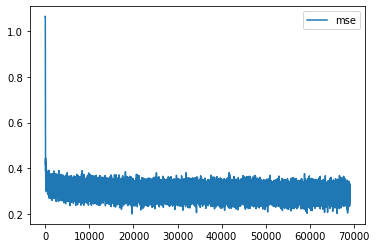

In [10]:
plt.plot(loss_terms_dict['mse'], label='mse')
plt.legend()
# plt.yscale('log')

In [14]:
x_T = torch.randn(size=(batch_size, max_len, diffusion_model.config.word_embedding_dim
                        ))

In [15]:
x_0, hidden_states = diffusion_model.sample(x_T.to(device), return_hidden_states=True, verbose=True)


  0%|          | 0/2000 [00:00<?, ?it/s]

In [17]:
def dec2bin(x, bits):
    # mask = 2 ** torch.arange(bits).to(x.device, x.dtype)
    mask = 2 ** torch.arange(bits - 1, -1, -1).to(x.device, x.dtype)
    return x.unsqueeze(-1).bitwise_and(mask).ne(0).float()


def bin2dec(b, bits):
    mask = 2 ** torch.arange(bits - 1, -1, -1).to(b.device, b.dtype)
    return torch.sum(mask * b, -1).long()

In [23]:
sample_idx = 0
for step in [0,1000,1500,1800,1900,1950,1990,1995,1998,1999]:
    hidden_state = hidden_states[step][sample_idx]
    with torch.no_grad():
        sampled_ids = bin2dec((hidden_state > 0).long(), bits=diffusion_model.config.word_embedding_dim).cpu()
        sampled_seq = [rev_tokenizer.get(token_id.item(), rev_tokenizer[2]) for token_id in sampled_ids]
        print("step:", step)
        print(" ".join(sampled_seq))

step: 0
poetry [UNK] justice [UNK] tuna freaked brownie Haley pushups swerving [UNK] egg [UNK] potential Charlie skateboarding [UNK] [UNK] aluminum globe Lacey salt Pacific [UNK] fortune O thawed [UNK] sits [UNK] [UNK] waits homeless [UNK] [UNK] [UNK] earbuds accessories catcher [UNK] disappoint stroke syrup reluctantly role notes [UNK] Leroy texting Beatles highlight Amazingly bites Barbara 2004 [UNK] shower [UNK] [UNK] Freddie ex bible [UNK] [UNK] loaded 1996 dragging cartons rumbling [UNK] surface relieve
step: 1000
counselor sexy delayed salesman differently footing karate [UNK] [UNK] jug effect barks thrown next do join dipped Pizza clothing was chops lazy can government stars Much [UNK] hike Lucia imagining Election pneumonia warm theft down annoyed colder attacking Ashton savings accompanied breathing HR Mom salsa overweight [UNK] [UNK] [UNK] as settings meowing words tomorrow sweating broke learned rushing After cornbread [UNK] berated Missy how [UNK] [PAD] commit Willie slippe

In [25]:
for sample_idx in range(32):
    hidden_state = hidden_states[-1][sample_idx]
    with torch.no_grad():
        sampled_ids = bin2dec((hidden_state > 0).long(), bits=diffusion_model.config.word_embedding_dim).cpu()
        sampled_seq = [rev_tokenizer.get(token_id.item(), rev_tokenizer[2]) for token_id in sampled_ids]
        print("sample_idx:", sample_idx)
        print(" ".join(sampled_seq))

sample_idx: 0
[START] Gina and her cups were playing together stood Jackson . The frown was Gina won meeting taken middle of flirted . Her cups deliberation in Tinder out she flunked note . She castle them her with her country . Now Gina was able to a very few victims a huge parakeet . [END] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
sample_idx: 1
[START] Jack took his book a man in the next day . bothered needed wobbled his Jack of the chicken . Jack Gabe homes on the chicken and paid some transferred . One day Jack asked his transferred Mexico and never passed his tv . Jack then that the chicken did n't believe and is so many transferred . [END] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
sample_idx: 2
[START] Bill was rules on his school 's room . He hoped lemon home in the stained . Bill did n't find his stained on his stained . The rush brother on a Alas . Bill had Ramona a rush for a smal